<a href="https://colab.research.google.com/github/OJB-Quantum/MuMax3-How-To/blob/main/Python%20Code_MuMax3%20Data%20Plots/STT_Effect_Visualization_with_MuMax3_in_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

In [1]:
#@title Check GPU + driver
!nvidia-smi --query-gpu="name,driver_version,compute_cap" --format=csv

name, driver_version, compute_cap
NVIDIA L4, 550.54.15, 8.9


In [2]:
#@title Install MuMax³ (MuMax³ 3.10 CUDA 10.1)
# Download the mumax3 binary
!wget -q https://mumax.ugent.be/mumax3-binaries/mumax3.10_linux_cuda10.1.tar.gz
!tar -xvf mumax3.10_linux_cuda10.1.tar.gz
!rm mumax3.10_linux_cuda10.1.tar.gz
!rm -rf mumax3.10 && mv mumax3.10_linux_cuda10.1 mumax3.10

# Update the PATH environment variable
import os
os.environ["PATH"] += ":/content/mumax3.10"

mumax3.10_linux_cuda10.1/
mumax3.10_linux_cuda10.1/mumax3-server
mumax3.10_linux_cuda10.1/lib/
mumax3.10_linux_cuda10.1/lib/libcurand.so.10
mumax3.10_linux_cuda10.1/lib/libcufft.so.10
mumax3.10_linux_cuda10.1/mumax3
mumax3.10_linux_cuda10.1/LICENSE
mumax3.10_linux_cuda10.1/mumax3-convert


In [3]:
# @title Utilities & Control Knobs
# @markdown Change any of the control knobs below, then re-run from here down.

from __future__ import annotations
import glob
import json
import math
import os
import pathlib
import re
import shutil
import subprocess
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (needed for 3D)
from IPython.display import HTML, display

# -----------------------------
# Control knobs (simulation)
# -----------------------------
sizeX_nm: float = 160.0  # @param {type:"number"}
sizeY_nm: float = 80.0   # @param {type:"number"}
sizeZ_nm: float = 5.0    # @param {type:"number"}

Nx: int = 64             # @param {type:"integer"}
Ny: int = 32             # @param {type:"integer"}

Msat_kA_per_m: float = 800.0    # @param {type:"number"}
Aex_pJ_per_m: float = 13.0      # @param {type:"number"}
alpha: float = 0.01             # @param {type:"number"}

Pol: float = 0.5669             # @param {type:"number"}
Lambda: float = 1.0             # @param {type:"number"}
EpsilonPrime: float = 0.0       # @param {type:"number"}

fixed_angle_deg: float = 20.0   # @param {type:"number"}
fixed_layer_pos: str = "top"    # @param ["top", "bottom"]

Jtot_A: float = -0.008          # @param {type:"number"}  # total current (A)
sim_time_ns: float = 1.0        # @param {type:"number"}
autosave_dt_ps: float = 100.0   # @param {type:"number"}
table_dt_ps: float = 10.0       # @param {type:"number"}

ovf_format: str = "OVF2_TEXT"   # @param ["OVF2_TEXT","OVF2_BINARY","OVF1_TEXT","OVF1_BINARY"]

# -----------------------------
# Control knobs (visualization)
# -----------------------------
downsample_step_x: int = 2   # @param {type:"integer"}  # arrow density control
downsample_step_y: int = 2   # @param {type:"integer"}
quiver_scale: float = 40.0   # @param {type:"number"}   # arrow scale factor
quiver_width: float = 0.002  # @param {type:"number"}   # arrow line width
heatmap_component: str = "mz"  # @param ["mz", "angle", "mx", "my"]
cmap_name: str = "coolwarm"    # @param ["coolwarm","RdBu_r","viridis","magma","inferno","turbo"]
vmin: float = -1.0           # @param {type:"number"}   # heat map colorbar min
vmax: float = +1.0           # @param {type:"number"}   # heat map colorbar max
fig_dpi: int = 120           # @param {type:"integer"}

# -----------------------------
# Derived constants & paths
# -----------------------------
WORK = pathlib.Path.cwd() / "stt_run"
OVF_DIR = WORK / "ovf"
NPY_DIR = WORK / "npy"
WORK.mkdir(parents=True, exist_ok=True)
OVF_DIR.mkdir(parents=True, exist_ok=True)
NPY_DIR.mkdir(parents=True, exist_ok=True)

def nm_to_m(val_nm: float) -> float:
    """Convert nanometers to meters."""
    return val_nm * 1e-9

def ps_to_s(val_ps: float) -> float:
    """Convert picoseconds to seconds."""
    return val_ps * 1e-12

def ns_to_s(val_ns: float) -> float:
    """Convert nanoseconds to seconds."""
    return val_ns * 1e-9

def fixed_layer_position_token(pos: str) -> str:
    """Map 'top'/'bottom' into MuMax3 enum tokens."""
    pos = pos.strip().lower()
    if pos == "top":
        return "FIXEDLAYER_TOP"
    if pos == "bottom":
        return "FIXEDLAYER_BOTTOM"
    raise ValueError("fixed_layer_pos must be 'top' or 'bottom'.")

def compute_current_density_Apm2(jtot_A: float, sizeX_m: float, sizeY_m: float) -> float:
    """Compute current density for an elliptical cross-section."""
    area_m2 = math.pi * sizeX_m * sizeY_m / 4.0
    return jtot_A / area_m2

def ensure_tools() -> None:
    """Raise if required tools are not found."""
    for tool in ("mumax3", "mumax3-convert"):
        tool_path = shutil.which(tool)
        if tool_path is None:
            raise RuntimeError(f"Required tool not found on PATH: {tool}")

def write_mumax3_script(dst_path: pathlib.Path) -> None:
    """Generate the MuMax3 input script (.mx3) with current control knob values."""
    sizeX_m = nm_to_m(sizeX_nm)
    sizeY_m = nm_to_m(sizeY_nm)
    sizeZ_m = nm_to_m(sizeZ_nm)
    jc = compute_current_density_Apm2(Jtot_A, sizeX_m, sizeY_m)
    angle_rad = math.radians(fixed_angle_deg)
    fl_token = fixed_layer_position_token(fixed_layer_pos)

    script = f"""
// Auto-generated STT simulation (MuMax3)
// Geometry
sizeX := {sizeX_m}
sizeY := {sizeY_m}
sizeZ := {sizeZ_m}

Nx := {Nx}
Ny := {Ny}

SetGridSize(Nx, Ny, 1)
SetCellSize(sizeX/Nx, sizeY/Ny, sizeZ)
SetGeom(Ellipse(sizeX, sizeY))

// Free layer
Msat  = {Msat_kA_per_m}e3
Aex   = {Aex_pJ_per_m}e-12
alpha = {alpha}
m     = Uniform(1, 0, 0)

// Slonczewski STT parameters
Lambda       = {Lambda}
Pol          = {Pol}
EpsilonPrime = {EpsilonPrime}
DisableZhangLiTorque = true

// Fixed layer polarization (in-plane)
angle := {fixed_angle_deg}
px := cos(angle * pi/180)
py := sin(angle * pi/180)
FixedLayer = Vector(px, py, 0)
FixedLayerPosition = {fl_token}

// Current injection (J along z)
Jtot := {Jtot_A}             // total current in A
area := sizeX*sizeY*pi/4
jc   := Jtot / area
J = Vector(0, 0, {jc})

// Output
OutputFormat = {ovf_format}  // OVF text/binary per control knob
AutoSave(m, {ps_to_s(autosave_dt_ps)})
TableAutoSave({ps_to_s(table_dt_ps)})
TableAdd(m.comp(0))  // mx average
TableAdd(m.comp(1))  // my average
TableAdd(m.comp(2))  // mz average

// Run
Run({ns_to_s(sim_time_ns)})
"""
    dst_path.write_text(script.strip() + "\n", encoding="utf-8")
    (WORK / "knobs.json").write_text(json.dumps({
        "sizeX_m": sizeX_m, "sizeY_m": sizeY_m, "sizeZ_m": sizeZ_m,
        "Nx": Nx, "Ny": Ny, "Msat_Apm": Msat_kA_per_m*1e3, "Aex_Jpm": Aex_pJ_per_m*1e-12,
        "alpha": alpha, "Pol": Pol, "Lambda": Lambda, "EpsilonPrime": EpsilonPrime,
        "fixed_angle_deg": fixed_angle_deg, "fixed_layer_pos": fixed_layer_pos,
        "Jtot_A": Jtot_A, "jc_Apm2": jc, "sim_time_s": ns_to_s(sim_time_ns),
        "autosave_dt_s": ps_to_s(autosave_dt_ps), "table_dt_s": ps_to_s(table_dt_ps),
        "ovf_format": ovf_format
    }, indent=2), encoding="utf-8")
    print(f"Wrote MuMax3 script to {dst_path}")


In [4]:
# @title Write MuMax3 script
ensure_tools()
mx3_path = WORK / "stt_sim.mx3"
write_mumax3_script(mx3_path)
print(mx3_path.read_text())


Wrote MuMax3 script to /content/stt_run/stt_sim.mx3
// Auto-generated STT simulation (MuMax3)
// Geometry
sizeX := 1.6e-07
sizeY := 8e-08
sizeZ := 5e-09

Nx := 64
Ny := 32

SetGridSize(Nx, Ny, 1)
SetCellSize(sizeX/Nx, sizeY/Ny, sizeZ)
SetGeom(Ellipse(sizeX, sizeY))

// Free layer
Msat  = 800.0e3
Aex   = 13.0e-12
alpha = 0.01
m     = Uniform(1, 0, 0)

// Slonczewski STT parameters
Lambda       = 1.0
Pol          = 0.5669
EpsilonPrime = 0.0
DisableZhangLiTorque = true

// Fixed layer polarization (in-plane)
angle := 20.0
px := cos(angle * pi/180)
py := sin(angle * pi/180)
FixedLayer = Vector(px, py, 0)
FixedLayerPosition = FIXEDLAYER_TOP

// Current injection (J along z)
Jtot := -0.008             // total current in A
area := sizeX*sizeY*pi/4
jc   := Jtot / area
J = Vector(0, 0, -795774715459.4767)

// Output
OutputFormat = OVF2_TEXT  // OVF text/binary per control knob
AutoSave(m, 1e-10)
TableAutoSave(1e-11)
TableAdd(m.comp(0))  // mx average
TableAdd(m.comp(1))  // my average
TableAdd

In [5]:
%%bash
set -euo pipefail

# Ensure output directory exists.
mkdir -p stt_run/ovf

# Run the simulation; direct all outputs into stt_run/ovf/
mumax3 -o stt_run/ovf stt_run/stt_sim.mx3

# Show a quick listing so you can verify outputs exist.
ls -l stt_run/ovf | head -n 20


//mumax 3.10 [linux_amd64 go1.14(gc) CUDA-10.1]
//GPU info: NVIDIA L4(22692MB), CUDA Driver 12.4, cc=8.9, using cc=75 PTX
//(c) Arne Vansteenkiste, Dynamat LAB, Ghent University, Belgium
//This is free software without any warranty. See license.txt
//********************************************************************//
//  If you use mumax in any work or publication,                      //
//  we kindly ask you to cite the references in references.bib        //
//********************************************************************//
//output directory: stt_run/ovf/
//starting GUI at http://127.0.0.1:35367
sizeX := 1.6e-07
sizeY := 8e-08
sizeZ := 5e-09
Nx := 64
Ny := 32
SetGridSize(Nx, Ny, 1)
SetCellSize(sizeX/Nx, sizeY/Ny, sizeZ)
SetGeom(Ellipse(sizeX, sizeY))
// Initializing geometry 3 %
// Initializing geometry 100 %
Msat = 800.0e3
Aex = 13.0e-12
alpha = 0.01
m = Uniform(1, 0, 0)
Lambda = 1.0
Pol = 0.5669
EpsilonPrime = 0.0
DisableZhangLiTorque = true
angle := 20.0
px := cos(angle 

//Did not use cached kernel: open /tmp/mumax3kernel_[64 32 1]_[0 0 0]_[2.5e-09 2.5e-09 5e-09]_6_0 0.ovf: no such file or directory
//Cached kernel: /tmp/mumax3kernel_[64 32 1]_[0 0 0]_[2.5e-09 2.5e-09 5e-09]_6_


In [6]:
%%bash
set -euo pipefail

# Convert all OVF magnetization fields to NumPy arrays for easy plotting.
cd stt_run
mkdir -p npy

# Pick the source directory that actually contains OVF frames.
# Prefer 'ovf/' (when you ran: mumax3 -o stt_run/ovf stt_run/stt_sim.mx3),
# otherwise fall back to the default 'stt_sim.out/' directory.
if ls ovf/m*.ovf >/dev/null 2>&1; then
  SRC_DIR="ovf"
elif ls stt_sim.out/m*.ovf >/dev/null 2>&1; then
  SRC_DIR="stt_sim.out"
else
  echo "ERROR: No OVF files found under 'ovf/' or 'stt_sim.out/'. Did the simulation run?" >&2
  exit 1
fi

echo "Converting OVF frames from: ${SRC_DIR}/"
mumax3-convert -numpy -o npy "${SRC_DIR}"/m*.ovf

echo "Converted files (showing up to 20):"
ls -l npy | head -n 20


Converting OVF frames from: ovf/
ovf/m000000.ovf
ovf/m000001.ovf
ovf/m000002.ovf
ovf/m000003.ovf
ovf/m000004.ovf
ovf/m000005.ovf
ovf/m000006.ovf
ovf/m000007.ovf
ovf/m000008.ovf
ovf/m000009.ovf
ovf/m000010.ovf
11 files converted,  0 skipped,  0 failed
Converted files (showing up to 20):
total 308
-rw-r--r-- 1 root root 24704 Oct 28 14:25 m000000.npy
-rw-r--r-- 1 root root 24704 Oct 28 14:25 m000001.npy
-rw-r--r-- 1 root root 24704 Oct 28 14:25 m000002.npy
-rw-r--r-- 1 root root 24704 Oct 28 14:25 m000003.npy
-rw-r--r-- 1 root root 24704 Oct 28 14:25 m000004.npy
-rw-r--r-- 1 root root 24704 Oct 28 14:25 m000005.npy
-rw-r--r-- 1 root root 24704 Oct 28 14:25 m000006.npy
-rw-r--r-- 1 root root 24704 Oct 28 14:25 m000007.npy
-rw-r--r-- 1 root root 24704 Oct 28 14:25 m000008.npy
-rw-r--r-- 1 root root 24704 Oct 28 14:25 m000009.npy
-rw-r--r-- 1 root root 24704 Oct 28 14:25 m000010.npy


[ ok ] ovf/m000000.ovf	-> npy/m000000.npy
[ ok ] ovf/m000003.ovf	-> npy/m000003.npy
[ ok ] ovf/m000001.ovf	-> npy/m000001.npy
[ ok ] ovf/m000002.ovf	-> npy/m000002.npy
[ ok ] ovf/m000006.ovf	-> npy/m000006.npy
[ ok ] ovf/m000004.ovf	-> npy/m000004.npy
[ ok ] ovf/m000008.ovf	-> npy/m000008.npy
[ ok ] ovf/m000007.ovf	-> npy/m000007.npy
[ ok ] ovf/m000009.ovf	-> npy/m000009.npy
[ ok ] ovf/m000005.ovf	-> npy/m000005.npy
[ ok ] ovf/m000010.ovf	-> npy/m000010.npy


In [7]:
# @title Load arrays and helpers
from typing import Optional

def list_frames() -> List[pathlib.Path]:
    """List all available NumPy frames converted from OVF magnetization."""
    return sorted(NPY_DIR.glob("m*.npy"))

def load_m_frame(path: pathlib.Path) -> np.ndarray:
    """Load a single magnetization frame from a NumPy file.

    Handles common layout variants by reshaping to (Ny, Nx, 3).
    """
    arr = np.load(path)
    # Try to infer shape robustly:
    # Possibilities: (Ny, Nx, 3), (Nx, Ny, 3), (3, Ny, Nx), (Nz, Ny, Nx, 3), (3, Nz, Ny, Nx)
    if arr.ndim == 3:
        if arr.shape[-1] == 3:
            # (Ny, Nx, 3) or (Nx, Ny, 3)
            ny, nx, c = arr.shape
            # Heuristic: prefer Nx = control knob Nx if possible
            if nx == Nx and ny == Ny:
                return arr
            if ny == Nx and nx == Ny:
                return np.transpose(arr, (1, 0, 2))
        if arr.shape[0] == 3:
            # (3, Ny, Nx)
            _, ny, nx = arr.shape
            arr = np.transpose(arr, (1, 2, 0))
            if ny == Ny and nx == Nx:
                return arr
    if arr.ndim == 4:
        # e.g., (Nz, Ny, Nx, 3) or (3, Nz, Ny, Nx)
        if arr.shape[-1] == 3:
            nz, ny, nx, _ = arr.shape
            arr2d = arr[0]  # take the single layer
            return arr2d if (ny == Ny and nx == Nx) else np.transpose(arr2d, (1, 0, 2))
        if arr.shape[0] == 3:
            # (3, Nz, Ny, Nx)
            _, nz, ny, nx = arr.shape
            arr2d = np.transpose(arr, (2, 3, 0))[..., 0:3]  # take layer 0
            return arr2d
    raise ValueError(f"Unsupported array shape for {path.name}: {arr.shape}")

def magnetization_components(m: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Split Ny×Nx×3 array into mx, my, mz."""
    return m[..., 0], m[..., 1], m[..., 2]

def magnetization_angle(mx: np.ndarray, my: np.ndarray) -> np.ndarray:
    """Compute in-plane angle (radians) of magnetization."""
    return np.arctan2(my, mx)

def mesh_xy_um() -> Tuple[np.ndarray, np.ndarray]:
    """Generate 2D meshgrid (in micrometers) matching the cell centers."""
    x = np.linspace(-sizeX_nm/2, sizeX_nm/2, Nx) * 1e-3
    y = np.linspace(-sizeY_nm/2, sizeY_nm/2, Ny) * 1e-3
    return np.meshgrid(x, y)

def ellipse_mask() -> np.ndarray:
    """Boolean mask for ellipse inside the simulation box for pretty plots."""
    X, Y = mesh_xy_um()
    a = (sizeX_nm/2) * 1e-3  # um
    b = (sizeY_nm/2) * 1e-3  # um
    return (X**2 / a**2 + Y**2 / b**2) <= 1.0


In [8]:
def load_m_frame(path: pathlib.Path) -> np.ndarray:
    """Load a single magnetization frame and return shape (Ny, Nx, 3).

    Robustly handles common layouts produced by mumax3-convert:
      - (Ny, Nx, 3)
      - (Nx, Ny, 3)
      - (3, Ny, Nx)
      - (Nz, Ny, Nx, 3)  with Nz possibly 1
      - (3, Nz, Ny, Nx)  with Nz possibly 1
    """
    arr = np.load(path)

    # 1) Remove trivial layer dimensions (e.g., Nz=1)
    arr = np.squeeze(arr)

    # 2) Find the magnetization component axis (size == 3). Prefer the last one if multiple.
    comp_axes = [i for i, s in enumerate(arr.shape) if s == 3]
    if not comp_axes:
        raise ValueError(f"{path.name}: expected a 3-component axis; got shape {arr.shape}")
    cax = comp_axes[-1]
    arr = np.moveaxis(arr, cax, -1)  # make components the last axis (..., 3)

    # 3) If there is still a layer axis (true multilayer), take the first layer by default.
    if arr.ndim == 4:
        # Interpret as (L, H, W, 3) and choose layer 0.
        arr = arr[0, ...]
        arr = np.squeeze(arr)

    # 4) Now expect either (H, W, 3) possibly transposed relative to (Ny, Nx, 3).
    if arr.ndim != 3 or arr.shape[-1] != 3:
        # As a last resort, try reshaping a flattened field (N, 3) if present.
        if arr.ndim == 2 and arr.shape[1] == 3 and arr.shape[0] == Nx * Ny:
            arr = arr.reshape(Ny, Nx, 3)
        else:
            raise ValueError(f"{path.name}: unsupported array shape after axis moves: {arr.shape}")

    h, w, _ = arr.shape
    if (h, w) == (Ny, Nx):
        return arr
    if (h, w) == (Nx, Ny):
        return np.transpose(arr, (1, 0, 2))

    # 5) If dimensions are swapped or flattened strangely but the pixel count matches, reshape.
    if h * w == Nx * Ny:
        return arr.reshape(Ny, Nx, 3)

    raise ValueError(f"{path.name}: cannot map shape {arr.shape} to (Ny={Ny}, Nx={Nx}, 3)")


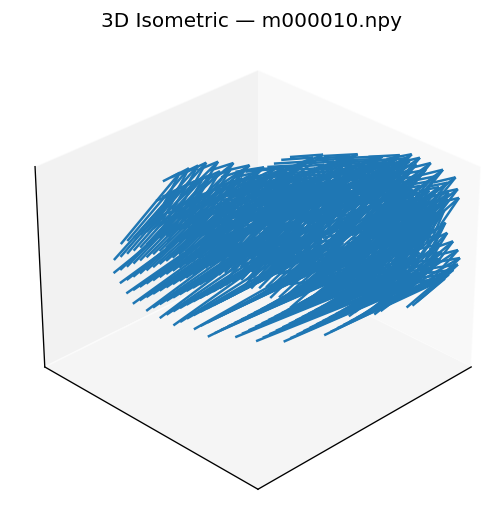

In [13]:
# @title 3D Isometric Quiver (Vector Field)
from typing import Optional
import pathlib
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

def plot_isometric_3d(
    frame_path: pathlib.Path,
    dsx: int = downsample_step_x,
    dsy: int = downsample_step_y,
    qlength: float = 0.06,
    qnorm: bool = False,
    elev: float = 30.0,
    azim: float = 45.0,
    dpi: int = fig_dpi,
) -> plt.Figure:
    """Render a 3D isometric quiver for a single frame.

    Args:
        frame_path: Path to .npy frame (converted from OVF).
        dsx, dsy: Downsampling stride for arrow density.
        qlength: Arrow length factor (visual only).
        qnorm: If True, normalize vectors to unit length.
        elev, azim: View angles for isometric-like perspective.
        dpi: Figure DPI.
    """
    m = load_m_frame(frame_path)
    mx, my, mz = magnetization_components(m)

    mask = ellipse_mask()
    X, Y = mesh_xy_um()
    Z = np.zeros_like(X)

    # Downsample and mask
    ds_mask = mask[::dsy, ::dsx]
    Xd = X[::dsy, ::dsx][ds_mask]
    Yd = Y[::dsy, ::dsx][ds_mask]
    Zd = Z[::dsy, ::dsx][ds_mask]
    U = mx[::dsy, ::dsx][ds_mask]
    V = my[::dsy, ::dsx][ds_mask]
    W = mz[::dsy, ::dsx][ds_mask]

    if qnorm:
        norm = np.sqrt(U**2 + V**2 + W**2) + 1e-12
        U, V, W = U / norm, V / norm, W / norm

    fig = plt.figure(figsize=(7.5, 4.5), dpi=dpi)
    ax = fig.add_subplot(111, projection="3d")
    ax.view_init(elev=elev, azim=azim)

    ax.quiver(Xd, Yd, Zd, U, V, W, length=qlength, normalize=False)

    # Clean: turn off panes, ticks, and grids
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.pane.set_edgecolor("w")
    ax.yaxis.pane.set_edgecolor("w")
    ax.zaxis.pane.set_edgecolor("w")
    ax.grid(False)
    ax.set_title(f"3D Isometric — {frame_path.name}")
    plt.tight_layout()
    return fig


# --- Self-contained frame discovery (prevents NameError) ---
try:
    frames = list_frames()  # uses helper from earlier cell, if present
except NameError:
    # Fallback: look directly in stt_run/npy for m*.npy
    frames = sorted(pathlib.Path("stt_run/npy").glob("m*.npy"))

assert frames, "No .npy frames found. Did the simulation and conversion run?"

# Plot the most recent frame
fig = plot_isometric_3d(frames[-1], qlength=0.08, qnorm=False)
plt.show()


In [14]:
# @title Make 2D Animation & Interactive Slider (self-contained & robust)
from __future__ import annotations
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from ipywidgets import interact, IntSlider

plt.rcParams['figure.dpi'] = 200

# ---- Fallbacks for globals if earlier "control knobs" cell not run ----
cmap_name = globals().get("cmap_name", "coolwarm")
vmin = float(globals().get("vmin", -1.0))
vmax = float(globals().get("vmax", 1.0))
downsample_step_x = int(globals().get("downsample_step_x", 2))
downsample_step_y = int(globals().get("downsample_step_y", 2))
quiver_scale = float(globals().get("quiver_scale", 40.0))
quiver_width = float(globals().get("quiver_width", 0.002))
fig_dpi = int(globals().get("fig_dpi", 120))
heatmap_component = globals().get("heatmap_component", "mz")
WORK = globals().get("WORK", pathlib.Path.cwd() / "stt_run")

# ---- Robust helpers (used if not already defined) ----
if "load_m_frame" not in globals():
    Nx = int(globals().get("Nx", 64))
    Ny = int(globals().get("Ny", 32))
    def load_m_frame(path: pathlib.Path) -> np.ndarray:
        """Load a magnetization frame (.npy) and return (Ny, Nx, 3)."""
        arr = np.load(path)
        arr = np.squeeze(arr)
        comp_axes = [i for i, s in enumerate(arr.shape) if s == 3]
        if not comp_axes:
            raise ValueError(f"{path.name}: no 3-component axis in shape {arr.shape}")
        arr = np.moveaxis(arr, comp_axes[-1], -1)
        if arr.ndim == 4:
            arr = np.squeeze(arr[0, ...])
        if arr.ndim == 3 and arr.shape[-1] == 3:
            h, w, _ = arr.shape
            if (h, w) == (Ny, Nx):
                return arr
            if (h, w) == (Nx, Ny):
                return np.transpose(arr, (1, 0, 2))
            if h * w == Nx * Ny:
                return arr.reshape(Ny, Nx, 3)
        if arr.ndim == 2 and arr.shape[1] == 3 and arr.shape[0] == Nx * Ny:
            return arr.reshape(Ny, Nx, 3)
        raise ValueError(f"{path.name}: cannot map shape {arr.shape} to (Ny={Ny}, Nx={Nx}, 3)")

if "magnetization_components" not in globals():
    def magnetization_components(m: np.ndarray):
        return m[..., 0], m[..., 1], m[..., 2]

if "magnetization_angle" not in globals():
    def magnetization_angle(mx: np.ndarray, my: np.ndarray) -> np.ndarray:
        return np.arctan2(my, mx)

def _safe_mask_and_grid(ny: int, nx: int):
    """Use ellipse_mask/mesh_xy_um if available; else normalized grid with circular mask."""
    try:
        mask = ellipse_mask()
        X, Y = mesh_xy_um()
        return mask, X, Y
    except Exception:
        x = np.linspace(-1.0, 1.0, nx)
        y = np.linspace(-1.0, 1.0, ny)
        X, Y = np.meshgrid(x, y)
        mask = (X**2 + Y**2) <= 1.0
        return mask, X, Y

def list_frames_local():
    """Find frames via helper or direct path lookup."""
    try:
        return list_frames()
    except Exception:
        return sorted((WORK / "npy").glob("m*.npy"))

frames = list_frames_local()
assert frames, "No .npy frames found. Did the simulation and conversion run?"

def plot_topdown_local(frame_path: pathlib.Path) -> plt.Figure:
    """Minimal 2D top-down plot (heat map + vector field) used by the slider."""
    m = load_m_frame(frame_path)
    mx, my, mz = magnetization_components(m)
    ny, nx = m.shape[:2]
    mask, X, Y = _safe_mask_and_grid(ny, nx)
    scalar_map = {
        "mz": mz,
        "mx": mx,
        "my": my,
        "angle": magnetization_angle(mx, my),
    }
    scalar = scalar_map.get(heatmap_component, mz)

    fig = plt.figure(figsize=(7, 3.2), dpi=fig_dpi)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect("equal")
    data = np.ma.array(scalar, mask=~mask)
    im = ax.imshow(
        data, origin="lower",
        extent=[X.min(), X.max(), Y.min(), Y.max()],
        cmap=cmap_name, vmin=vmin, vmax=vmax, interpolation="nearest",
    )

    ds_mask = mask[::downsample_step_y, ::downsample_step_x]
    Xd = X[::downsample_step_y, ::downsample_step_x][ds_mask]
    Yd = Y[::downsample_step_y, ::downsample_step_x][ds_mask]
    MXd = mx[::downsample_step_y, ::downsample_step_x][ds_mask]
    MYd = my[::downsample_step_y, ::downsample_step_x][ds_mask]
    ax.quiver(
        Xd, Yd, MXd, MYd,
        angles="xy", scale_units="xy",
        scale=quiver_scale, width=quiver_width, pivot="mid",
    )

    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04).set_label(f"{heatmap_component} (arb. units)")
    ax.set_title(f"2D Top-Down — {frame_path.name}")
    plt.tight_layout()
    return fig

def plot_topdown_for_index(idx: int) -> plt.Figure:
    """Helper to quickly draw 2D top-down for frame index idx."""
    return plot_topdown_local(frames[idx])

def animate_topdown_mp4(mp4_path: pathlib.Path, fps: int = 12) -> HTML:
    """Create an animation cycling through all frames; save MP4 if ffmpeg is available."""
    fig = plt.figure(figsize=(7, 3.2), dpi=fig_dpi)
    img_ax = fig.add_subplot(1, 1, 1)
    img_ax.set_aspect("equal")
    img_ax.set_xticks([]); img_ax.set_yticks([])
    for s in img_ax.spines.values():
        s.set_visible(False)

    m0 = load_m_frame(frames[0])
    ny, nx = m0.shape[:2]
    mask, X, Y = _safe_mask_and_grid(ny, nx)

    def draw_frame(i: int):
        m = load_m_frame(frames[i])
        mx, my, mz = magnetization_components(m)
        scalar_map = {
            "mz": mz,
            "mx": mx,
            "my": my,
            "angle": magnetization_angle(mx, my),
        }
        scalar = scalar_map.get(heatmap_component, mz)
        data = np.ma.array(scalar, mask=~mask)
        img_ax.imshow(
            data, origin="lower",
            extent=[X.min(), X.max(), Y.min(), Y.max()],
            cmap=cmap_name, vmin=vmin, vmax=vmax, interpolation="nearest",
        )
        ds_mask = mask[::downsample_step_y, ::downsample_step_x]
        Xd = X[::downsample_step_y, ::downsample_step_x][ds_mask]
        Yd = Y[::downsample_step_y, ::downsample_step_x][ds_mask]
        MXd = mx[::downsample_step_y, ::downsample_step_x][ds_mask]
        MYd = my[::downsample_step_y, ::downsample_step_x][ds_mask]
        img_ax.quiver(
            Xd, Yd, MXd, MYd,
            angles="xy", scale_units="xy",
            scale=quiver_scale, width=quiver_width, pivot="mid",
        )

    def init():
        img_ax.clear()
        img_ax.set_aspect("equal")
        img_ax.set_xticks([]); img_ax.set_yticks([])
        for s in img_ax.spines.values():
            s.set_visible(False)
        draw_frame(0)
        return []

    def update(i):
        img_ax.clear()
        img_ax.set_aspect("equal")
        img_ax.set_xticks([]); img_ax.set_yticks([])
        for s in img_ax.spines.values():
            s.set_visible(False)
        draw_frame(i)
        return []

    anim = animation.FuncAnimation(
        fig, update, init_func=init, frames=len(frames),
        blit=False, interval=max(1, int(1000//fps))
    )
    mp4_path = pathlib.Path(mp4_path)
    mp4_path.parent.mkdir(parents=True, exist_ok=True)
    try:
        anim.save(str(mp4_path), writer="ffmpeg", dpi=fig_dpi, fps=fps)
        plt.close(fig)
        print(f"Saved animation to {mp4_path}")
        return HTML(f'<video controls src="{mp4_path.as_posix()}"></video>')
    except Exception as exc:
        print(f"FFmpeg unavailable or failed ({exc}); falling back to inline HTML animation.")
        plt.close(fig)
        return HTML(anim.to_jshtml())

# --- Produce outputs ---
video_html = animate_topdown_mp4(WORK / "stt_topdown.mp4", fps=12)
display(video_html)

_ = interact(
    plot_topdown_for_index,
    idx=IntSlider(min=0, max=len(frames)-1, step=1, value=len(frames)-1)
)


Saved animation to /content/stt_run/stt_topdown.mp4


interactive(children=(IntSlider(value=10, description='idx', max=10), Output()), _dom_classes=('widget-interac…

In [15]:
# @title Export selected frames as PNG (self-contained & robust)
from __future__ import annotations
import pathlib
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

# ---- Fallbacks for globals if earlier cells weren't run ----
fig_dpi = int(globals().get("fig_dpi", 120))
WORK = globals().get("WORK", pathlib.Path.cwd() / "stt_run")
cmap_name = globals().get("cmap_name", "coolwarm")
vmin = float(globals().get("vmin", -1.0))
vmax = float(globals().get("vmax", 1.0))
downsample_step_x = int(globals().get("downsample_step_x", 2))
downsample_step_y = int(globals().get("downsample_step_y", 2))
quiver_scale = float(globals().get("quiver_scale", 40.0))
quiver_width = float(globals().get("quiver_width", 0.002))
heatmap_component = globals().get("heatmap_component", "mz")
Nx = int(globals().get("Nx", 64))
Ny = int(globals().get("Ny", 32))

# ---- Robust helpers (used if not already defined) ----
if "load_m_frame" not in globals():
    def load_m_frame(path: pathlib.Path) -> np.ndarray:
        """Load a magnetization frame (.npy) and return (Ny, Nx, 3)."""
        arr = np.load(path)
        arr = np.squeeze(arr)  # remove Nz=1 if present
        # find component axis (size==3), prefer the last one
        comp_axes = [i for i, s in enumerate(arr.shape) if s == 3]
        if not comp_axes:
            raise ValueError(f"{path.name}: no 3-component axis in shape {arr.shape}")
        arr = np.moveaxis(arr, comp_axes[-1], -1)  # ... x 3
        # if still 4D (true multilayer), take first layer
        if arr.ndim == 4:
            arr = np.squeeze(arr[0, ...])
        # map onto (Ny, Nx, 3)
        if arr.ndim == 3 and arr.shape[-1] == 3:
            h, w, _ = arr.shape
            if (h, w) == (Ny, Nx):
                return arr
            if (h, w) == (Nx, Ny):
                return np.transpose(arr, (1, 0, 2))
            if h * w == Nx * Ny:
                return arr.reshape(Ny, Nx, 3)
        # flattened (N,3) fallback
        if arr.ndim == 2 and arr.shape[1] == 3 and arr.shape[0] == Nx * Ny:
            return arr.reshape(Ny, Nx, 3)
        raise ValueError(f"{path.name}: cannot map shape {arr.shape} to (Ny={Ny}, Nx={Nx}, 3)")

if "magnetization_components" not in globals():
    def magnetization_components(m: np.ndarray):
        return m[..., 0], m[..., 1], m[..., 2]

if "magnetization_angle" not in globals():
    def magnetization_angle(mx: np.ndarray, my: np.ndarray) -> np.ndarray:
        return np.arctan2(my, mx)

def _safe_mask_and_grid(ny: int, nx: int):
    """Use ellipse_mask/mesh_xy_um if available; else normalized grid with circular mask."""
    try:
        mask = ellipse_mask()
        X, Y = mesh_xy_um()
        return mask, X, Y
    except Exception:
        x = np.linspace(-1.0, 1.0, nx)
        y = np.linspace(-1.0, 1.0, ny)
        X, Y = np.meshgrid(x, y)
        mask = (X**2 + Y**2) <= 1.0
        return mask, X, Y

def _list_frames_local():
    """Find frames via helper or direct path lookup."""
    try:
        return list_frames()
    except Exception:
        return sorted((WORK / "npy").glob("m*.npy"))

# ---- Discover frames ----
frames = _list_frames_local()
assert frames, "No .npy frames found. Did the simulation and conversion run?"

# ---- Choose which frames to export ----
N = len(frames)
_default_indices = [0, N // 2, N - 1]
_export_indices = globals().get("export_indices", _default_indices)

# sanitize indices: clamp to [0, N-1], allow negatives like -1, deduplicate, sort
clean_idx = []
for idx in _export_indices:
    i = int(idx)
    if i < 0:
        i += N
    i = max(0, min(N - 1, i))
    clean_idx.append(i)
export_indices = sorted(set(clean_idx))

# ---- Destination directory ----
png_dir = WORK / "png"
png_dir.mkdir(parents=True, exist_ok=True)

# ---- Local plotting function or use user's existing one ----
def plot_topdown_local(frame_path: pathlib.Path):
    if "plot_topdown" in globals():
        return plot_topdown(frame_path)  # use your full-featured version
    # minimal, gridless top-down plot
    m = load_m_frame(frame_path)
    mx, my, mz = magnetization_components(m)
    ny, nx = m.shape[:2]
    mask, X, Y = _safe_mask_and_grid(ny, nx)
    scalar = {
        "mz": mz,
        "mx": mx,
        "my": my,
        "angle": magnetization_angle(mx, my),
    }.get(heatmap_component, mz)

    fig = plt.figure(figsize=(7, 3.2), dpi=fig_dpi)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect("equal")
    data = np.ma.array(scalar, mask=~mask)
    im = ax.imshow(
        data,
        origin="lower",
        extent=[X.min(), X.max(), Y.min(), Y.max()],
        cmap=cmap_name, vmin=vmin, vmax=vmax,
        interpolation="nearest",
    )
    ds_mask = mask[::downsample_step_y, ::downsample_step_x]
    Xd = X[::downsample_step_y, ::downsample_step_x][ds_mask]
    Yd = Y[::downsample_step_y, ::downsample_step_x][ds_mask]
    MXd = mx[::downsample_step_y, ::downsample_step_x][ds_mask]
    MYd = my[::downsample_step_y, ::downsample_step_x][ds_mask]
    ax.quiver(
        Xd, Yd, MXd, MYd,
        angles="xy", scale_units="xy",
        scale=quiver_scale, width=quiver_width, pivot="mid",
    )
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04).set_label(f"{heatmap_component} (arb. units)")
    ax.set_title(f"2D Top-Down — {frame_path.name}")
    plt.tight_layout()
    return fig

# ---- Export PNGs ----
for idx in export_indices:
    fig = plot_topdown_local(frames[idx])
    out_path = png_dir / f"frame_{idx:04d}.png"
    fig.savefig(out_path, dpi=fig_dpi, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved {out_path}")


Saved /content/stt_run/png/frame_0000.png
Saved /content/stt_run/png/frame_0005.png
Saved /content/stt_run/png/frame_0010.png
